# Импорты библиотек

In [0]:
# библиотеки для визуализации и работы с данными
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

In [0]:
# настройки для визуализации
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

In [0]:
# библиотеки для создания тренировочных и обучающих сетов
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score,recall_score
from sklearn.metrics import confusion_matrix,roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

In [0]:
# библиотека для препроцессинга и создания аугментаций
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [0]:
# библиотеки машинного обучения
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical

In [0]:
# импорты для СНС
from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
 
import tensorflow as tf
import random as rn

In [0]:
# остальные импорты для загрузки изображений, деархивации и пр.
import cv2                  
import numpy as np  
from tqdm import tqdm
import os                   
from random import shuffle  
from zipfile import ZipFile
from PIL import Image

# Подготовка датасета

In [0]:
# скачиваем датасет с google drive
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Аутентификация и создание PyDrive клиента
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
# ссылка общего доступа на датасет из гугл диска
link = 'https://drive.google.com/open?id=1V_LiCGV1Ap6xZrwLoJG99pwD7QRG6QLh'
# название архива с датасетом 
dataset_zip_name='flowers.zip'

In [0]:
# скачиваем датасет
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile(dataset_zip_name)  

In [0]:
# разархивирование скачанного датасетаa
!unzip $dataset_zip_name -d 'flowers/'

In [0]:
# массив для всех изображений
img_data = []
# массив для классов изображений
labels = []
# пути к датасетам
FLOWER_DAISY_DIR='flowers/flowers/daisy/'
FLOWER_SUNFLOWER_DIR='flowers/flowers/sunflower/'
FLOWER_TULIP_DIR='flowers/flowers/tulip/'
FLOWER_DANDI_DIR='flowers/flowers/dandelion/'
FLOWER_ROSE_DIR='flowers/flowers/rose/'

In [0]:
# размер, к которому приводятся все изображения
image_size = 150

In [0]:
"""
Функция для итерации всех изображений в папке directory, приведению к размеру size и заполнению массивов 
img_data и labels
"""
def iter_images(directory,label):
  for img in tqdm(os.listdir(directory)):
    try:
      path = os.path.join(directory,img)
      img = cv2.imread(path,cv2.IMREAD_COLOR)
      img = cv2.resize(img, (image_size,image_size))

      img_data.append(img)
      labels.append(str(label))
    except:
        pass

In [0]:
# обрабатываем маргаритки
iter_images(FLOWER_DAISY_DIR,'Daisy')

100%|██████████| 769/769 [00:01<00:00, 428.09it/s]


In [0]:
# обрабатываем одуванчики
iter_images(FLOWER_DANDI_DIR,'Dandelion')

100%|██████████| 1055/1055 [00:02<00:00, 418.18it/s]


In [0]:
# обрабатываем розы
iter_images(FLOWER_ROSE_DIR,'Rose')

100%|██████████| 784/784 [00:01<00:00, 453.74it/s]


In [0]:
# обрабатываем подсолнухи
iter_images(FLOWER_SUNFLOWER_DIR,'Sunflower')

100%|██████████| 734/734 [00:01<00:00, 369.12it/s]


In [0]:
# обрабатываем тюльпан
iter_images(FLOWER_TULIP_DIR,'Tulip')

100%|██████████| 984/984 [00:02<00:00, 418.23it/s]


In [0]:
# проверяем, все ли изображения были добавлены в массив
print(len(img_data))

4323


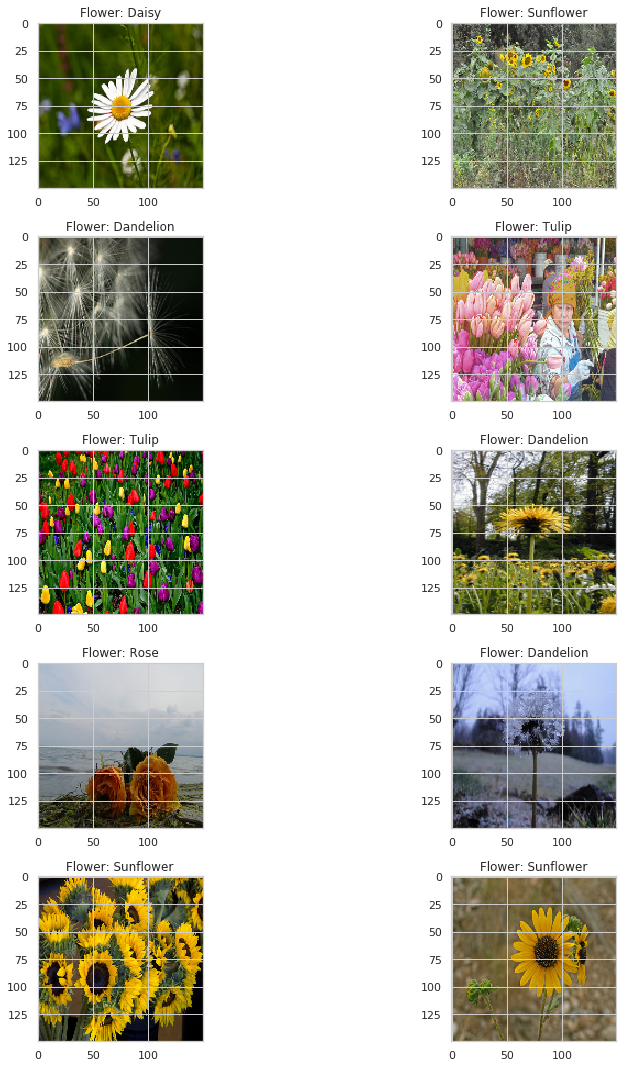

In [0]:
# визуализируем рандомные загруженные изображения
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (2):
        l=rn.randint(0,len(labels))
        ax[i,j].imshow(cv2.cvtColor(img_data[l], cv2.COLOR_BGR2RGB))
        ax[i,j].set_title('Flower: '+labels[l])
        
plt.tight_layout()

In [0]:
# нормализуем данные изображений
data = np.asarray(img_data)
data = data / 255.0

In [0]:
# конвертируем стринговые названия в численные коды от 0 до 4
labels = np.asarray(labels)
le=LabelEncoder()
label_codes=le.fit_transform(labels)
label_codes=to_categorical(label_codes,5)

In [0]:
# разбиваем данные на обучающие и тестовые
x_train, x_test, y_train, y_test = train_test_split(data, label_codes, test_size=0.3, shuffle= True)

Объём выборки - 4323 изображения

Объём тренировочного сета - 70% объема выборки = ~3026 изображений

Объём тестировочного сета - 30% объема выборки = ~1297 изображений

# Модель сверточной НС

In [0]:
from keras.layers import Conv2D,MaxPool2D,Flatten,Dense

# устанавливаем начальное случайное значение
np.random.seed(42)
rn.seed(42)
tf.set_random_seed(42)

"""
Строим последовательну модель, содержащую 4 сверточных+пулинг слоя, один скрытый слой из 512 нейронов 
и 5 выходных нейронов, отвечающих за классы 
"""
model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (image_size,image_size,3)))
model.add(MaxPooling2D(pool_size=(2,2)))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
 

model.add(Conv2D(filters =96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters = 96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(5, activation = "softmax"))

In [0]:
# сведения о модели
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 150, 150, 32)      2432      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 37, 37, 96)        55392     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 18, 18, 96)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 18, 18, 96)        83040     
__________

In [0]:
# конфигурация отжига
from keras.callbacks import ReduceLROnPlateau
red_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1)

In [0]:
# генерируем аугментации, чтобы избежать переобучения
datagen = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False, 
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range=10,  # случайно поворачивать изображения в диапазоне
        zoom_range = 0.1, # случайно зумить изображение
        width_shift_range=0.2,  # случайно изменять ширину изображения
        height_shift_range=0.2,  # случайно изменять высоту изображения
        horizontal_flip=True,  # случайно горизонтально отражать изображения 
        vertical_flip=False)  # случайно вертикально отражать изображения 


datagen.fit(x_train)

In [0]:
# компилируем модель
model.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

In [0]:
# обучение модели
batch_size = 64
epochs = 25
History = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                               epochs = epochs, validation_data = (x_test,y_test),
                               verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size)

# Визуализация модели


**Отображение ядер свертки с весами**

In [0]:
from matplotlib.pyplot import figure
from matplotlib import pyplot
# выведем информацию о сверточных слоях модели
number = 0
for layer in model.layers:
  number += 1
  if 'conv' not in layer.name:
    continue

  filters, biases = layer.get_weights()
  print(number-1, layer.name, filters.shape)


0 conv2d_1 (5, 5, 3, 32)
2 conv2d_2 (3, 3, 32, 64)
4 conv2d_3 (3, 3, 64, 96)
6 conv2d_4 (3, 3, 96, 96)


In [0]:

# метод, выводящий фильтры (ядра с вевсами) данного слоя
# layer_number - номер слоя в модели
# channels - количество каналов, для которых выводим фильтры
# filters_amount - количество фильтров, которые выводятся для каждого канала
def show_filters(layer_number,channels_amount,filters_amount):
  # настроим кионфигруацию вывода изображений
  figure(num=None, figsize=(8, 8), dpi=120, facecolor='w', edgecolor='k')
  
  filters, biases = model.layers[layer_number].get_weights()
  # нормализуем значения фильтров
  f_min, f_max = filters.min(), filters.max()
  filters = (filters - f_min) / (f_max - f_min)
  # n_filters - количество фильтров на каждый канал
  n_filters, ix = filters_amount, 1
  
  # количество изображений в одном ряду
  subplot_amount = math.ceil(math.sqrt(channels_amount*filters_amount))

  for i in range(n_filters):
    f = filters[:,:,:,i]
    for j in range(channels_amount):
      ax = pyplot.subplot(subplot_amount, subplot_amount, ix)
      ax.set_xticks([])
      ax.set_yticks([])
      pyplot.imshow(f[:,:,j],cmap='gray')
      ix+=1
  pyplot.show()

In [0]:
# метод, выводящий фильтры первого слоя в цвете
# filters_amount - количество фильтров
def show_filters_first_layer(filters_amount):
  # настроим кионфигруацию вывода изображений
  figure(num=None, figsize=(12, 12), dpi=120)
  
  filters, biases = model.layers[0].get_weights()
  # нормализуем значения фильтров
  f_min, f_max = filters.min(), filters.max()
  filters = (filters - f_min) / (f_max - f_min)
  # n_filters - количество фильтров на каждый канал
  n_filters, ix = filters_amount, 1
  
  for i in range(n_filters):
    f = filters[:,:,:,i]
    filter_rgb = np.zeros((5,5,3))
    for j in range(3):
      filter_rgb[:,:,j]=f[:,:,j]
    
    filter_rgb = cv2.resize(filter_rgb, (15, 15), cv2.INTER_LINEAR)
    ax = pyplot.subplot(8, 8, ix)
    ax.set_xticks([])
    ax.set_yticks([])
    pyplot.imshow(filter_rgb)
    ix+=1
  pyplot.show()

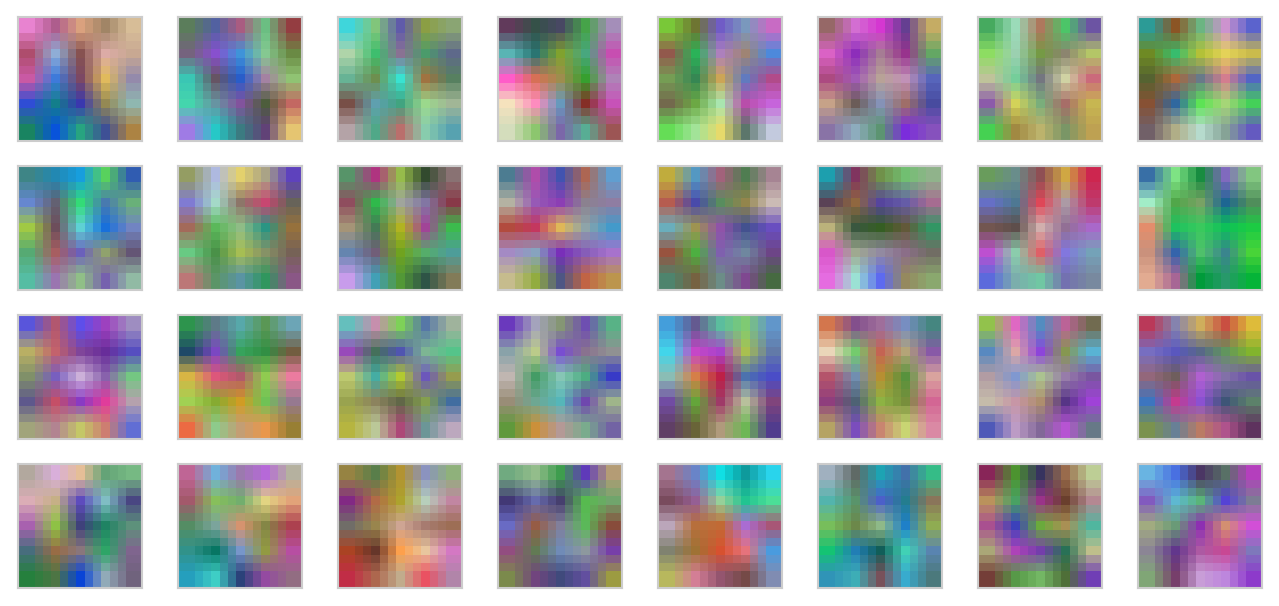

In [0]:
# выведем фильтры первого сверточного слоя в цвете
show_filters_first_layer(32)

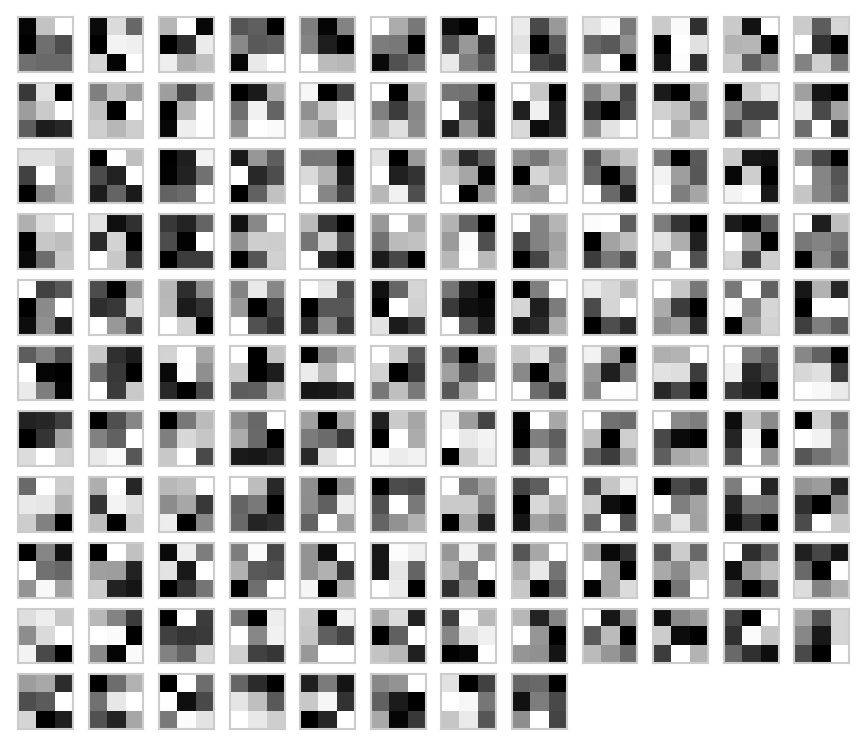

In [0]:
# выведем фильтры второго сверточного слоя
show_filters(2,32,4)

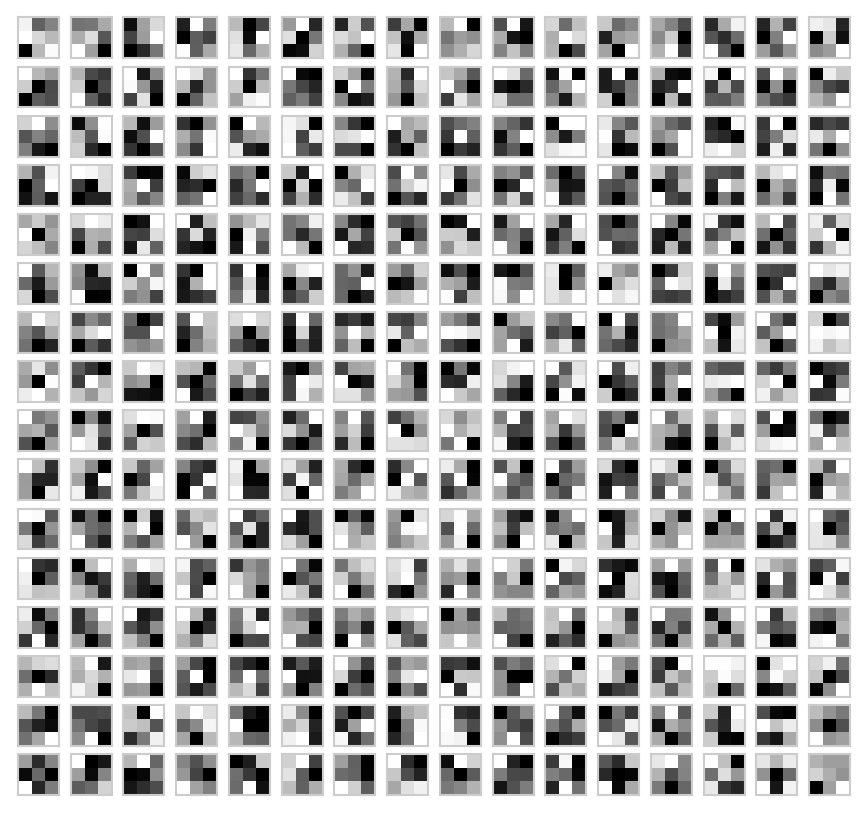

In [0]:
# выведем примеры фильтров третьего сверточного слоя
show_filters(4,64,4)

**Построение карт характеристик для изображения**

In [0]:
# загружаем изображение для вывода feature maps
from google.colab import files
uploaded = files.upload()

Saving oduvanchik.jpg to oduvanchik.jpg


In [0]:
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import Model
from matplotlib import pyplot
from numpy import expand_dims

# создадим модель для фич, содержащую выходы светочных слоёв основной модели
ixs = [0, 2, 4, 6]
outputs = [model.layers[i].output for i in ixs]
model_for_features = Model(inputs=model.inputs, outputs=outputs)

# загрузим изображение и приведем к требуемому размеру для модели
img_path='oduvanchik.jpg'
img = cv2.imread(img_path,cv2.IMREAD_COLOR)
img = cv2.resize(img, (image_size,image_size))

# конвертируем изображение в массив
img = img_to_array(img)
img = expand_dims(img, axis=0)
# нормализуем изображение
img = img / 255.0
# массив, содержащий карты фич для всех сверточных слоёв
feature_maps = model_for_features.predict(img)
# инофрмация о модели для фич
model_for_features.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1_input (InputLayer)  (None, 150, 150, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 150, 32)      2432      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 37, 37, 96)        55392     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 18, 18, 96)        0         
__________

In [0]:
# метод, выводящий карту фич fmap, содержащий x_number*y_number изображений
def show_feature_map(fmap,x_number,y_number):
  # конфигурация вывода изображения
  figure(num=None, figsize=(12, 12), dpi=120, facecolor='w', edgecolor='k')
  ix = 1
  for _y in range(y_number):
    for _x in range(x_number):
      
      if(ix-1 < fmap.shape[3]) :
        ax = pyplot.subplot(y_number, x_number, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # выводим в палитре jet
        pyplot.imshow(fmap[0, :, :, ix-1], cmap='jet')
      ix += 1
  pyplot.show()

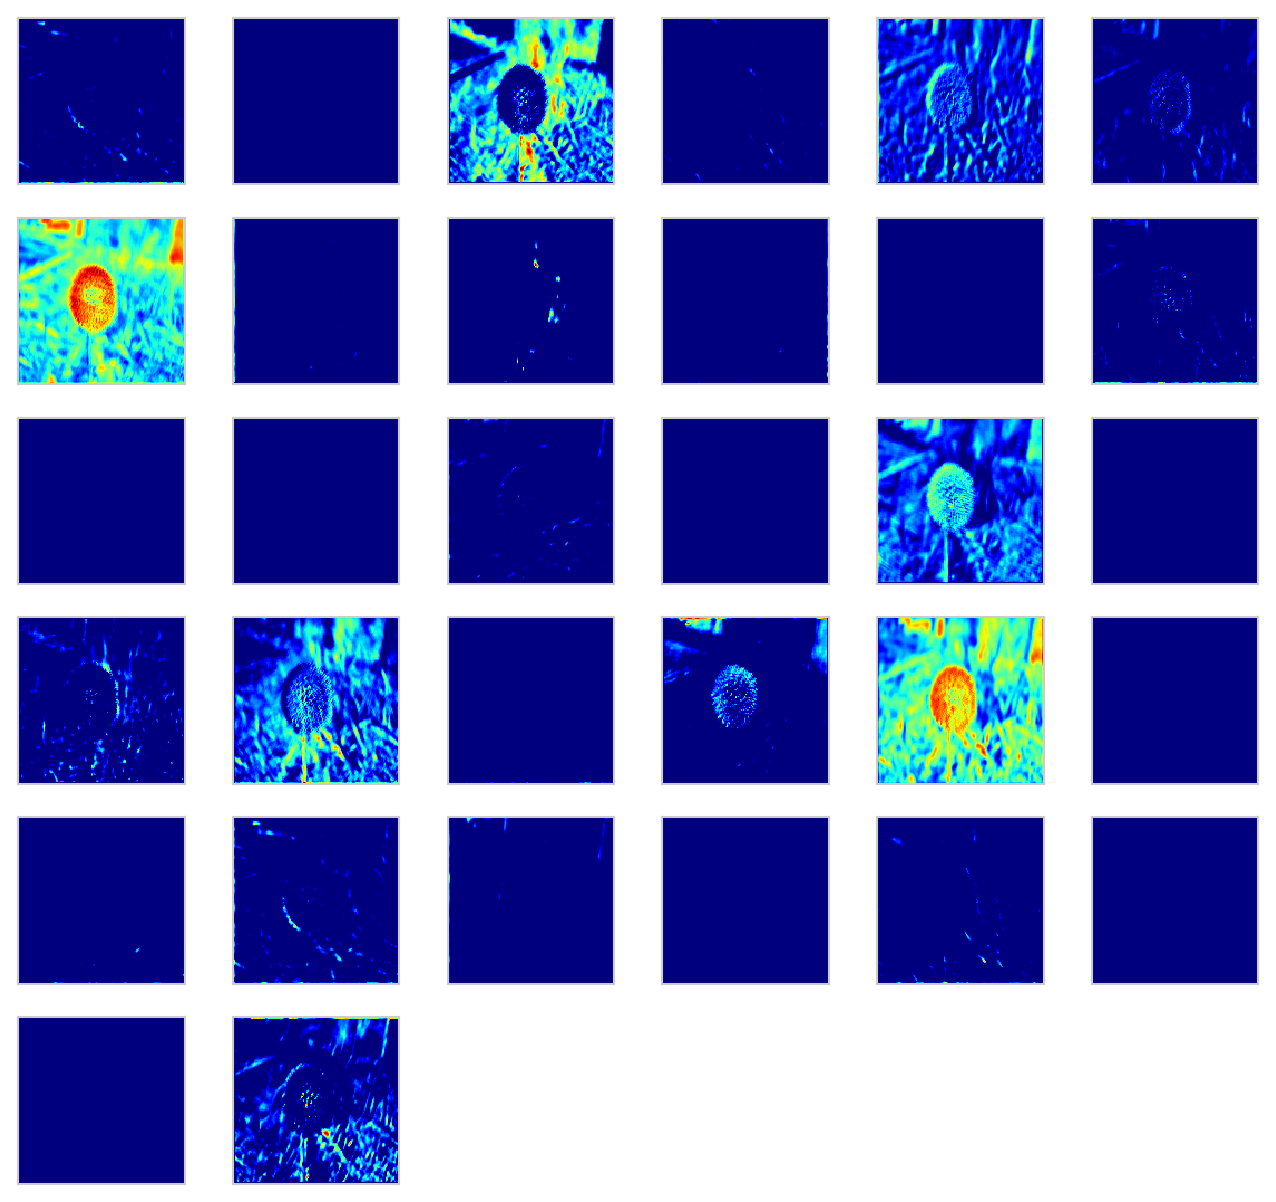

In [0]:
# строим карту характеристик 1 сверточного слоя
show_feature_map(feature_maps[0],6,6)

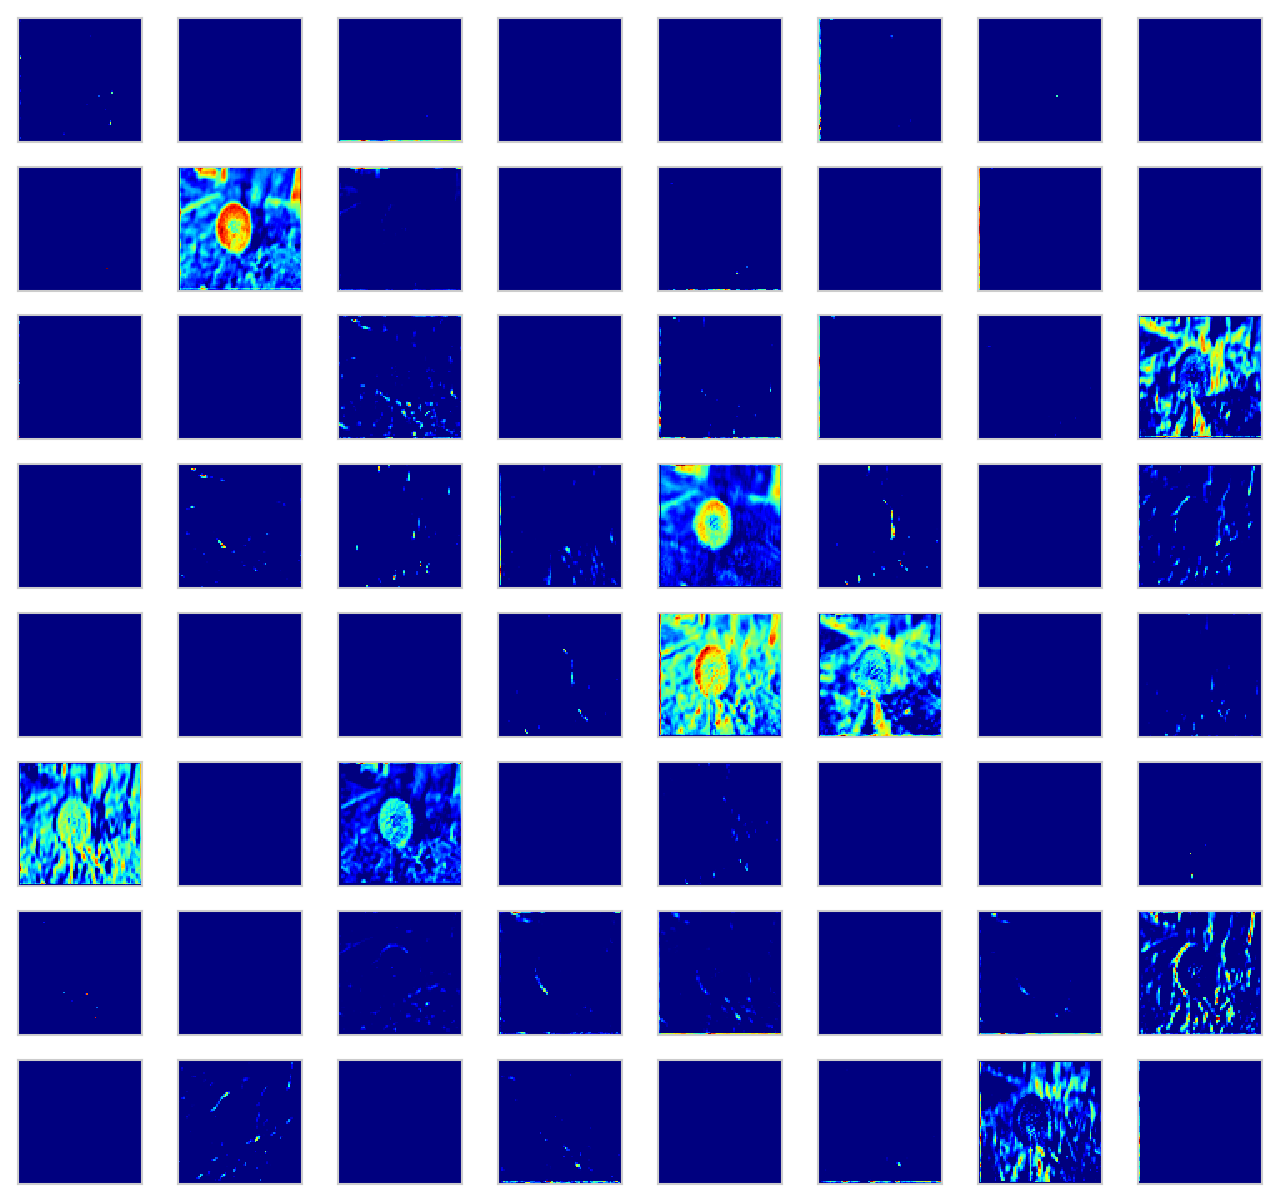

In [0]:
# строим карту характеристик 2 сверточного слоя
show_feature_map(feature_maps[1],8,8)

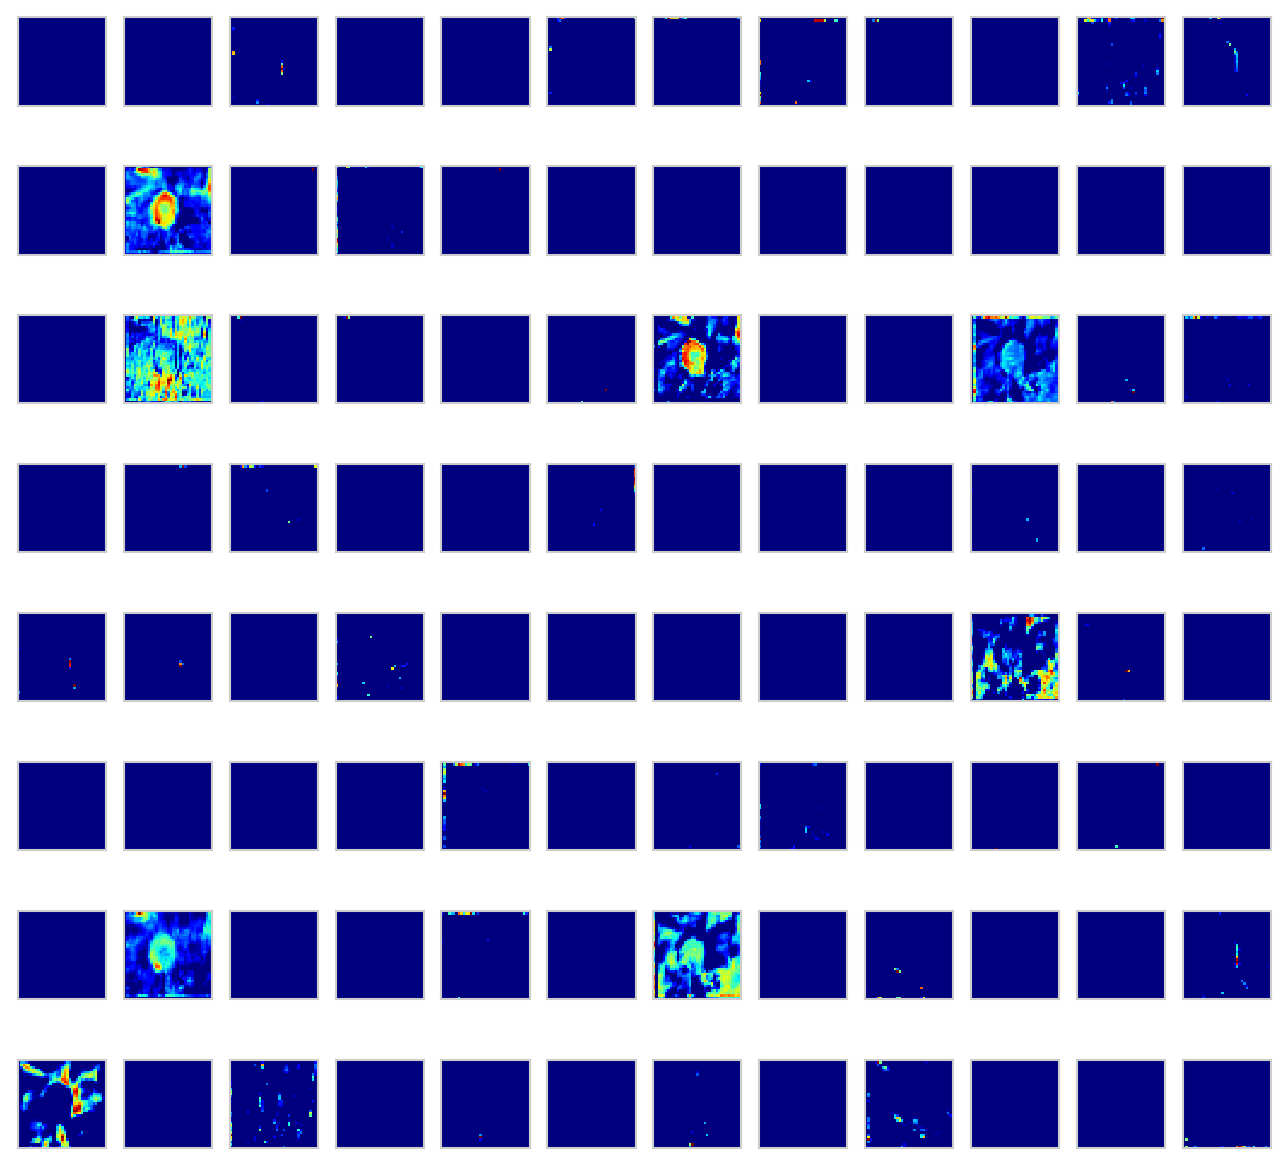

In [0]:
# строим карту характеристик 3 сверточного слоя
show_feature_map(feature_maps[2],12,8)

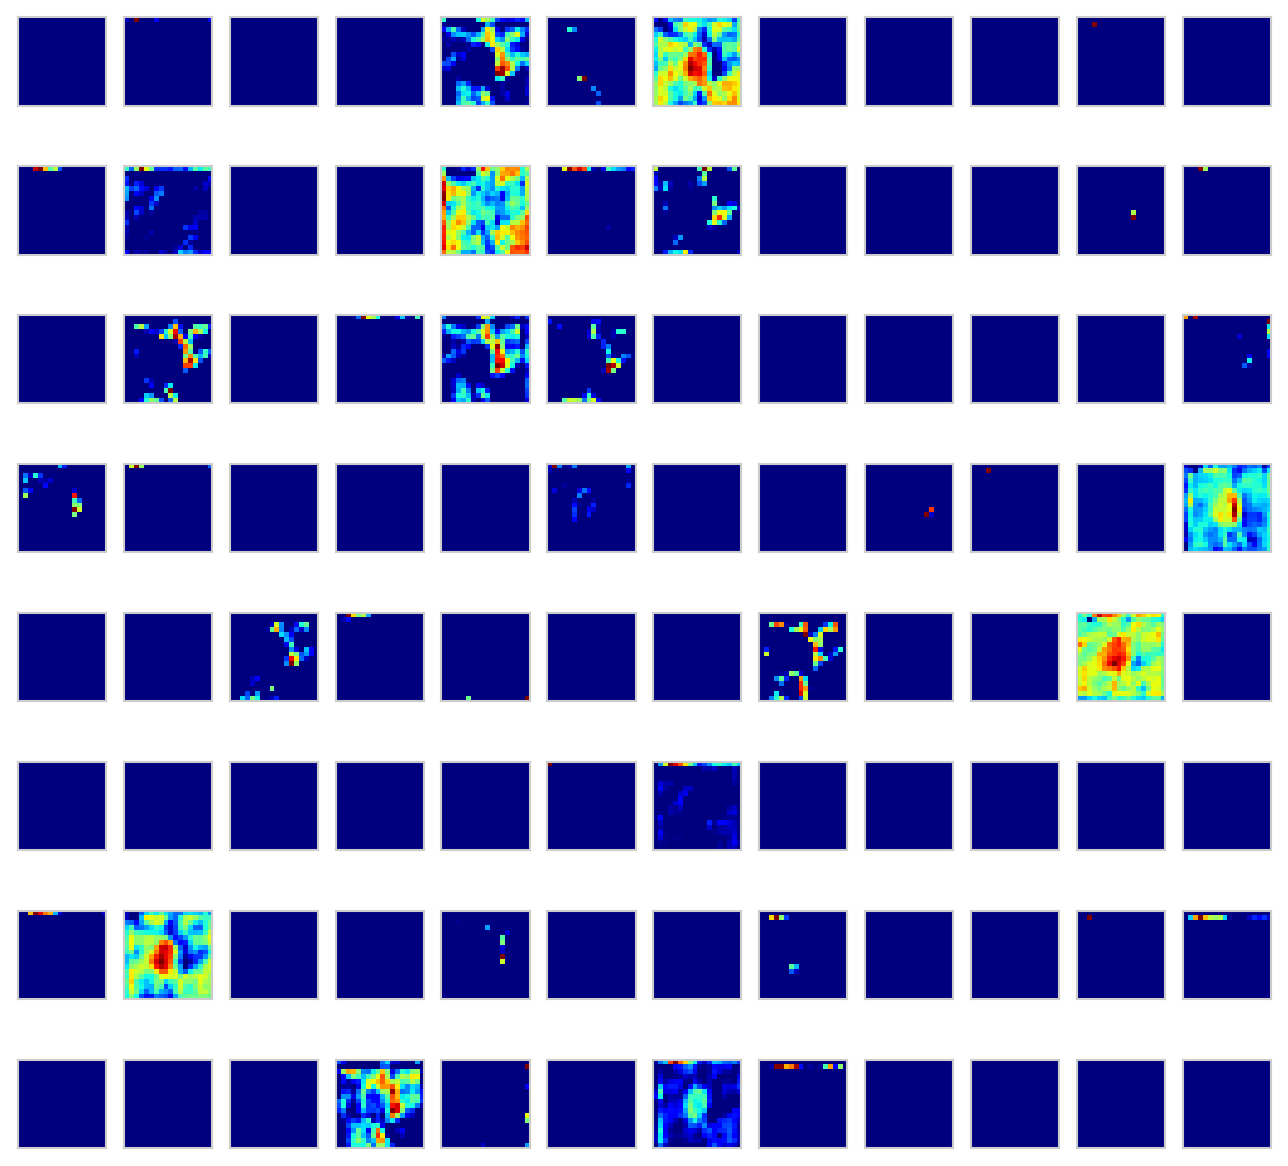

In [0]:
# строим карту характеристик 4 сверточного слоя
show_feature_map(feature_maps[3],12,8)

**Визуализация фильтров при помощи градиентного восхождения**

In [0]:
# создадим словарь соотносящий назвние слоя со слоем модели
layer_dict = dict([(layer.name, layer) for layer in model.layers])


In [0]:
# функция чтобы преобразовать тензор в правильное изображение
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # ограничим отрезком [0,1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # конвертируем в массив RGB 
    x *= 255
    x = x.transpose((1, 0, 2))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [0]:
from keras import backend as K
from scipy.ndimage.filters import median_filter

# функция визуализации фильтров при помощи градиентного восхождения
# layer_name - название слоя (напр. conv2d_1)
# filter_index - номер фильтра 
# x_number - количество изображений в ширину
# y_number - количество изображений в высоту
def gradient_ascent(layer_name, filters_list) :
  ix = 1
  input_img = model.input
  
  figure(num=None, figsize=(12, 12), dpi=120)
  
  # количество изображений в одном ряду
  subplot_amount = math.ceil(math.sqrt(len(filters_list)))
  
  for filter_index in filters_list:
    # строим функцию потерь, котороая максимизируют активационную функцию
    # n-го фильтра рассматриваемого слоя
    layer_output = layer_dict[layer_name].output
    loss = K.mean(layer_output[:, :, :, filter_index])

    # расчёт градиента входного изображения и запись потерь при расчёте
    grads = K.gradients(loss, input_img)[0]

    # нормализация градиента
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

    # эта функция возвращает потери и градиент данного входного изображения
    iterate = K.function([input_img], [loss, grads])

    # создадим серое изображение со случайным шумом
    input_img_data = np.random.random((1, image_size, 
                                       image_size, 3)) * 20 + 128.
    
    # препроцессинг изображения, чтобы модель его приняла
    input_img_data = input_img_data / 255.0
    
    # размер шага для градиентного восхождения
    step = 6.
    
    # количество итераций 
    mIter = 1001
    # параметры медианной фильтрации изображения
    mFilterSize = 3
    mFilterEvery = 30

    # запускаем градиентное восхождение на mIter шагов
    for i in range(mIter):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step

        input_img_data = np.clip(input_img_data, 0., 1.)

        if mFilterSize is not 0 and i % mFilterEvery == 0:
            input_img_data = median_filter(input_img_data, size=(mFilterSize, 
                                                                 mFilterSize, 
                                                                 1, 1))
    img_2 = input_img_data[0]
    img_2 = deprocess_image(img_2)
    
    ax = pyplot.subplot(subplot_amount, subplot_amount, ix)
    plt.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title("Фильтр "+str(filter_index))
    pyplot.imshow(img_2, cmap=plt.cm.binary)
    ix += 1
    
pyplot.show()

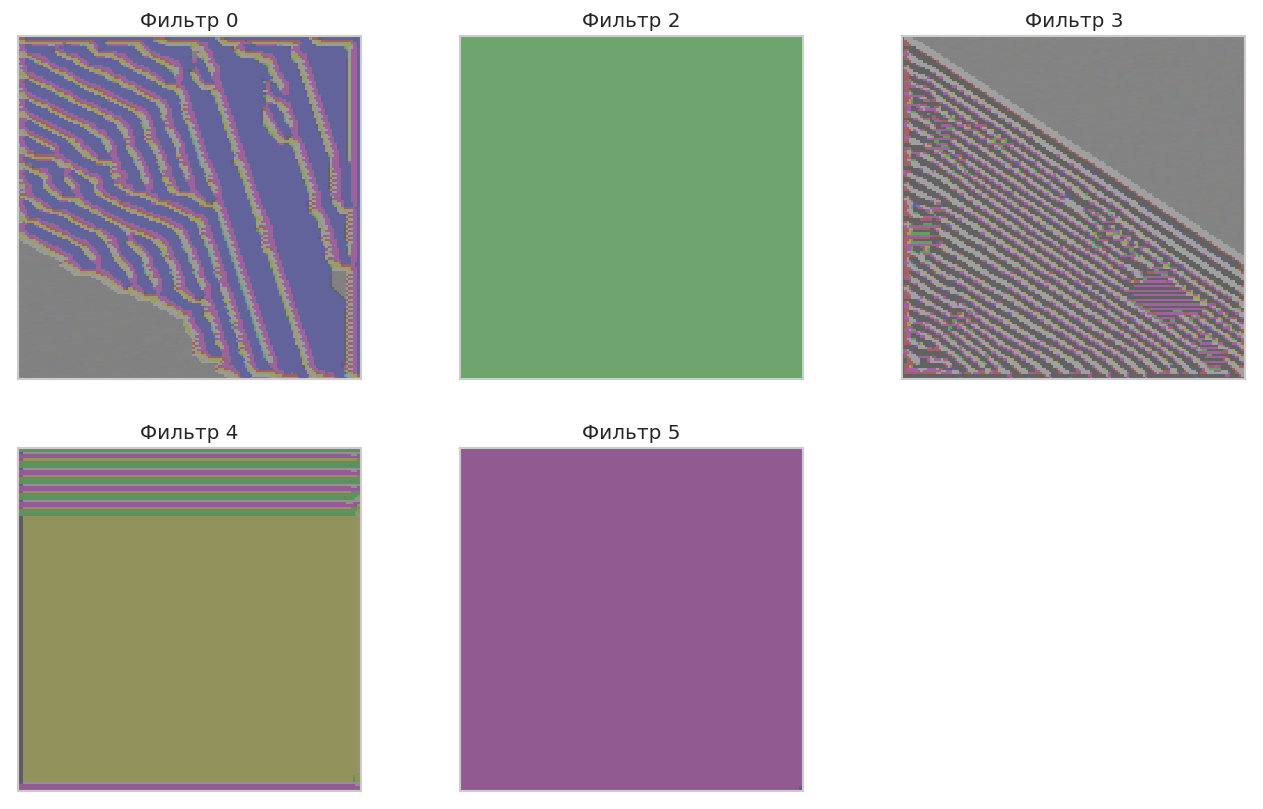

In [0]:
# визуализируем 5 фильтров первого сверточного слоя
gradient_ascent("conv2d_1",[0,2,3,4,5])
  


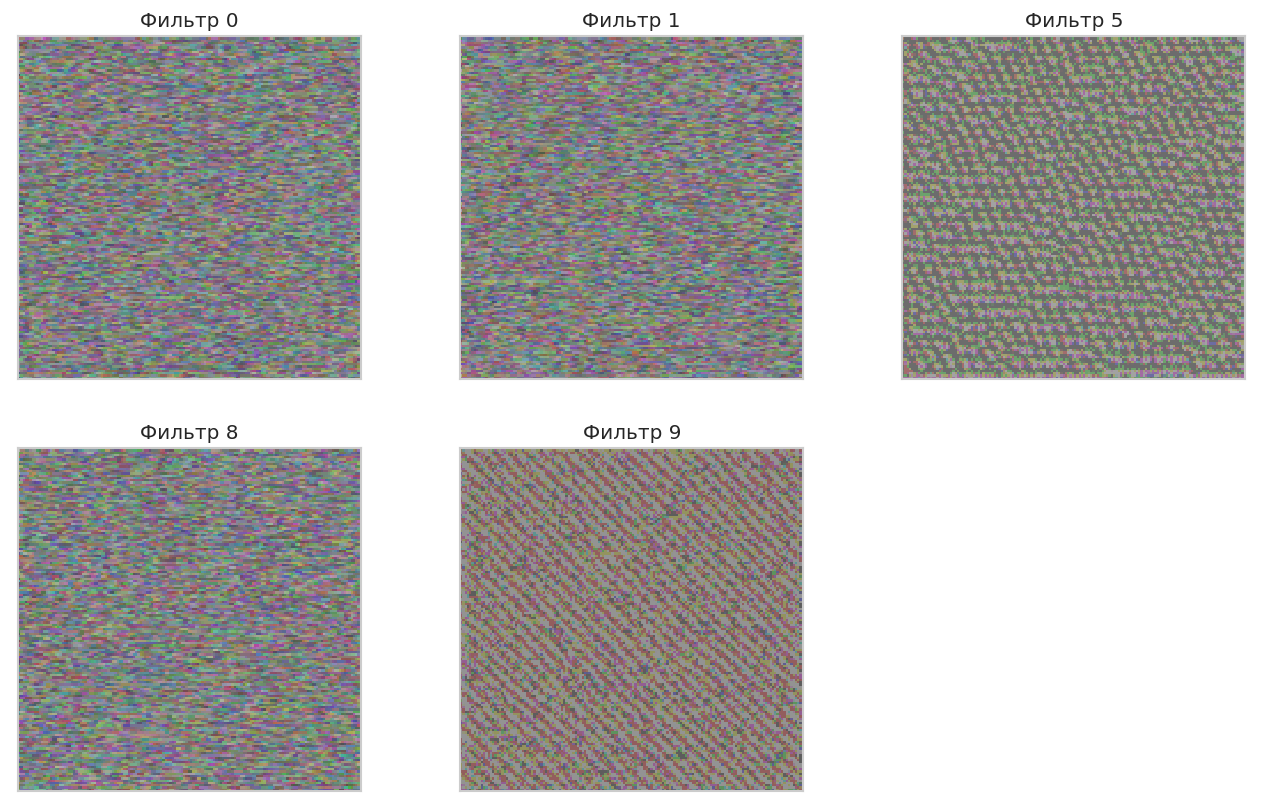

In [0]:
# визуализируем 5 фильтров второго сверточного слоя
gradient_ascent("conv2d_2",[0,1,5,8,9])

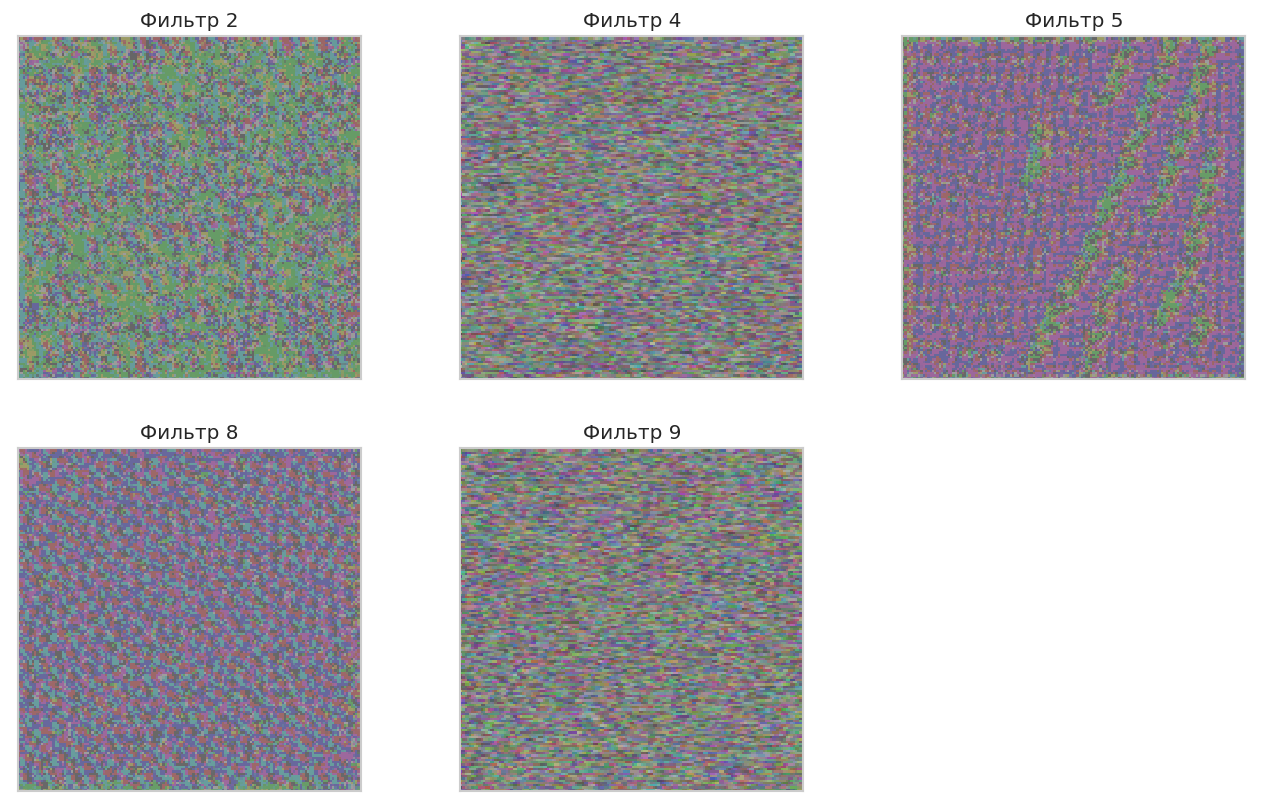

In [0]:
# визуализируем 5 фильтров третьего сверточного слоя
gradient_ascent("conv2d_3",[2,4,5,8,9])

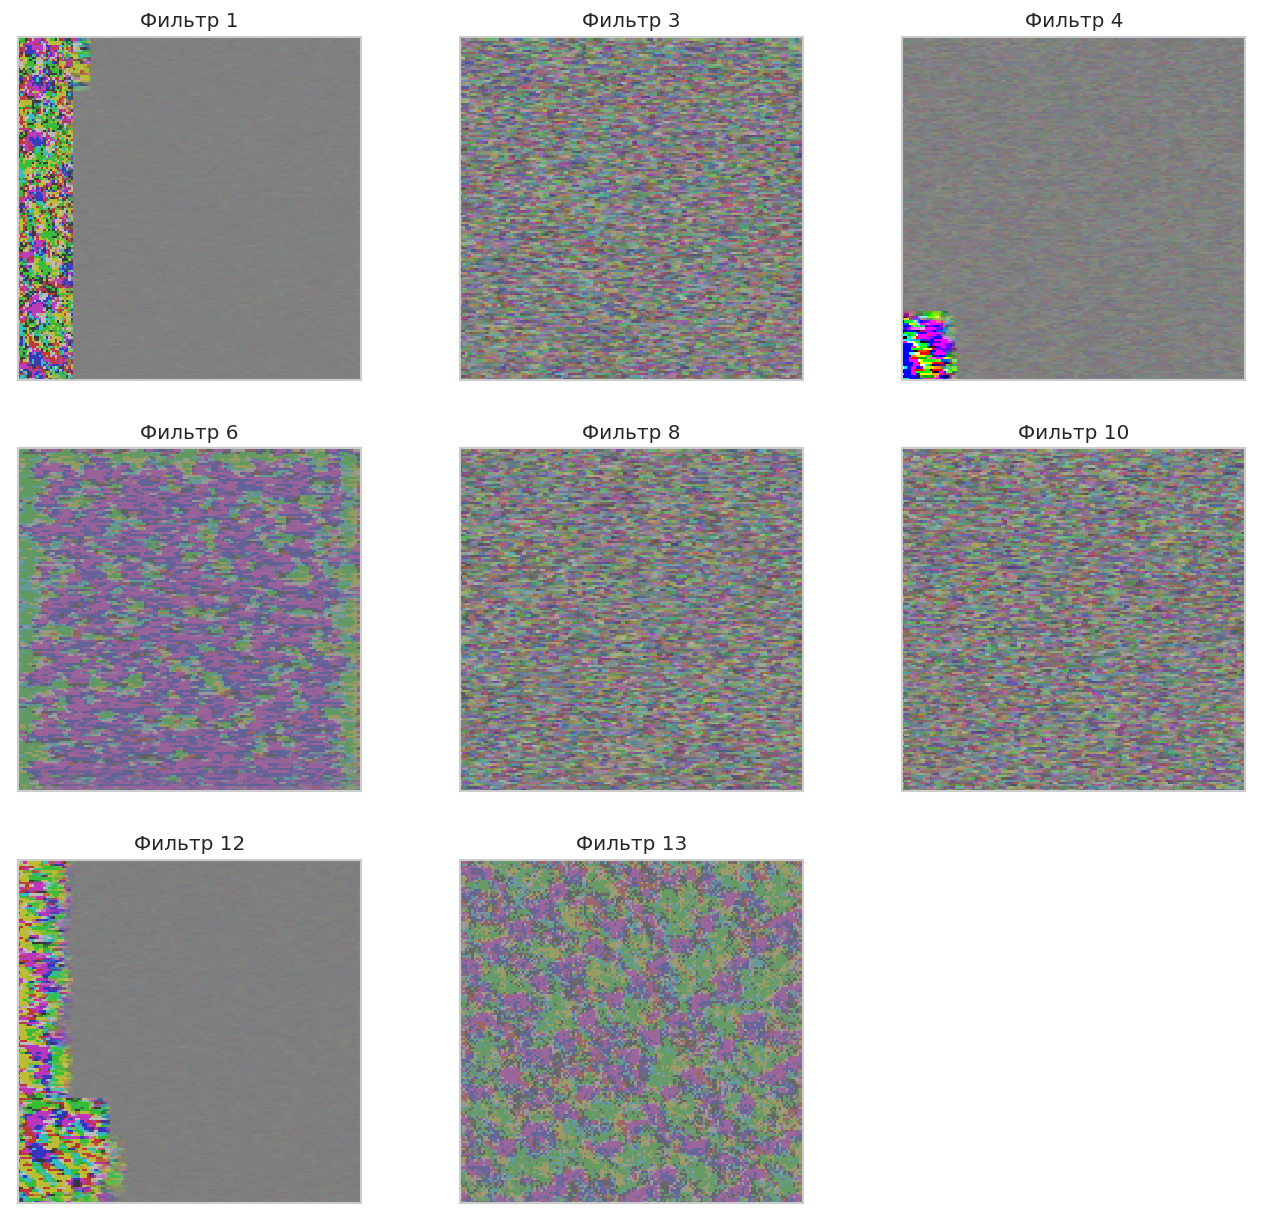

In [0]:
# визуализируем 8 фильтров четвертого сверточного слоя
gradient_ascent("conv2d_4",[1,3,4,6,8,10,12,13])

**Визуализация работы СНС при помощи Grad Cam**

In [0]:
'''
Метод отображает на изображении наиболее вероятное размещение класса
image_path - путь к изображени
cls - класс, который мы ищем (есл)
  если cls == -1, то ищем 
  то, что распознала сетка
layer_name - название последнего сверточного слоя
'''
def grad_cam(image_path, cls=-1, layer_name='conv2d_4'):
  # загружаем изображение и преобразовываем размер
  image = cv2.imread(image_path,cv2.IMREAD_COLOR)
  image = cv2.resize(image, (image_size,image_size))

  # конвертируем изображение в массив
  preproc_image = img_to_array(image)
  preproc_image = expand_dims(preproc_image, axis=0)
  # нормализуем изображение
  preproc_image = preproc_image / 255.0
  # предсказываем класс изображения
  predictions = model.predict(preproc_image)
  predict = np.argmax(predictions)
  # если заренее не указан класс, который мы ищем, то ищем 
  # то, что распознала сетка
  if cls == -1:
      cls = predict

  """
  Метод градиентно-взвешенного отображения активации классов
  """
  y_c = model.output[0, cls]
  conv_output = layer_dict[layer_name].output
  grads = K.gradients(y_c, conv_output)[0]

  gradient_function = K.function([model.input], [conv_output, grads])

  output, grads_val = gradient_function([preproc_image])
  output, grads_val = output[0, :], grads_val[0, :, :, :]

  weights = np.mean(grads_val, axis=(0, 1))
  cam = np.dot(output, weights)

  # увеличим размер полученного изображения до размера входного изображения
  cam = cv2.resize(cam, (image_size, image_size), cv2.INTER_LINEAR)
  cam = np.maximum(cam, 0)
  cam = cam / cam.max()

  plt.figure(figsize=(15, 10))
  plt.subplot(131)
  plt.title('Предсказан - ' + str(le.inverse_transform([predict])) + '\n')
  plt.axis('off')
  plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
  plt.imshow(cam, cmap='jet', alpha=0.5)
  
  return cam
    

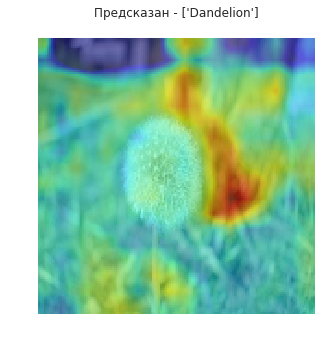

In [0]:
gradcam = grad_cam("oduvanchik.jpg",layer_name="conv2d_4")

**Визуализация работы СНС при помощи Guided Backpropagation**

In [0]:
# сохраним веса
model.save_weights('model.h5')

In [0]:
import tensorflow as tf
from tensorflow.python.framework import ops

def build_guided_model():
    """
    Функция возвращает модифицированную модель
    
    Изменяет градиентную функцию для всех ReLu активационных функций, что
    требуется для метода обученного обратного распространения ошибки
    """
    if "GuidedBackProp" not in ops._gradient_registry._registry:
        @ops.RegisterGradient("GuidedBackProp")
        def _GuidedBackProp(op, grad):
            dtype = op.inputs[0].dtype
            return grad * tf.cast(grad > 0., dtype) * \
                   tf.cast(op.inputs[0] > 0., dtype)

    g = tf.get_default_graph()
    with g.gradient_override_map({'Relu': 'GuidedBackProp'}):
        new_model = Sequential()
        new_model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                         activation ='relu', 
                         input_shape = (image_size,image_size,3)))
        new_model.add(MaxPooling2D(pool_size=(2,2)))


        new_model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',
                         activation ='relu'))
        new_model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))


        new_model.add(Conv2D(filters =96, kernel_size = (3,3),padding = 'Same',
                         activation ='relu'))
        new_model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

        new_model.add(Conv2D(filters = 96, kernel_size = (3,3),padding = 'Same',
                         activation ='relu'))
        new_model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

        new_model.add(Flatten())
        new_model.add(Dense(512))
        new_model.add(Activation('relu'))
        new_model.add(Dense(5, activation = "softmax"))
        new_model.load_weights('model.h5')
    return new_model

In [0]:
# строим управляемую модель
guided_model = build_guided_model()

In [0]:
# выведем информацию об управляемой модели, чтобы опеределить название
# последнего сверточного слоя
guided_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 150, 150, 32)      2432      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 37, 37, 96)        55392     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 18, 18, 96)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 18, 18, 96)        83040     
__________

In [0]:
def guided_backprop(image_path, layer_name='conv2d_8'):
  
  # загружаем изображение и преобразовываем размер
  image = cv2.imread(image_path,cv2.IMREAD_COLOR)
  image = cv2.resize(image, (image_size,image_size))

  # конвертируем изображение в массив
  preproc_image = img_to_array(image)
  preproc_image = expand_dims(preproc_image, axis=0)
  # нормализуем изображение
  preproc_image = preproc_image / 255.0
      
  """
  Метод обученного обратного распространения ошибки
  """
  input_imgs = guided_model.input
  layer_output = guided_model.get_layer(layer_name).output
  grads = K.gradients(layer_output, input_imgs)[0]
  backprop_fn = K.function([input_imgs, K.learning_phase()], [grads])
  grads_val = backprop_fn([preproc_image, 0])[0]
  
  plt.figure(figsize=(15, 10))
  plt.subplot(132)
  plt.title('Guided Backprop')
  plt.axis('off')
  plt.imshow(deprocess_image(grads_val[0]))
  return grads_val[0]

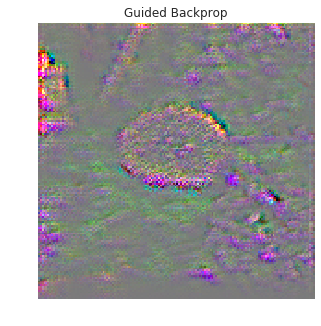

In [0]:
gb_colored = guided_backprop("oduvanchik.jpg")

**Совмещение методов Guided Backpropagation и Grad Cam**

In [0]:
# перемножаем две получившиеся после gb и grad cam матрицы
guided_gradcam = gb_colored * gradcam[..., np.newaxis]

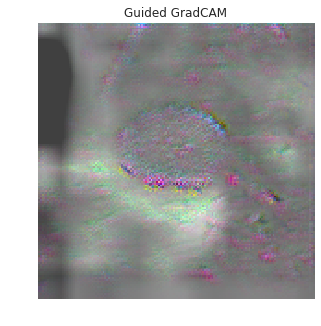

In [0]:
# отобразим результат
plt.figure(figsize=(15, 10))
plt.subplot(133)
plt.title('Guided GradCAM')
plt.axis('off')
plt.imshow(np.flip(deprocess_image(guided_gradcam), -1))
plt.show()

**Визуализация работы СНС при помощи Saliency map**

In [0]:
"""
    Конвертирует цветное GB в saliency map
Args:
    im_as_arr (numpy arr): RGB изображение с формой (W,H,3) (0-255)
returns:
    grayscale_im (numpy_arr): Черно-белое изображение 
"""
def convert_to_grayscale(im_as_arr):
  im_as_arr = im_as_arr / 255.0
  
  im_as_arr[:,:,:] = [x - 0.5 for x in im_as_arr]
  
  grayscale_im = np.sum(np.abs(im_as_arr), axis=2)
  im_max = np.percentile(grayscale_im, 99)
  im_min = np.min(grayscale_im)
  grayscale_im = (np.clip((grayscale_im - im_min) / (im_max - im_min), 0, 1))

  return grayscale_im

In [0]:
gb_gray = convert_to_grayscale(deprocess_image(gb_colored))

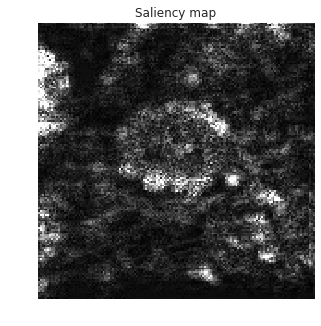

In [0]:
plt.figure(figsize=(15, 10))
plt.subplot(132)
plt.title('Saliency map')
plt.axis('off')
plt.imshow(gb_gray,cmap='gray')

# Оценка модели

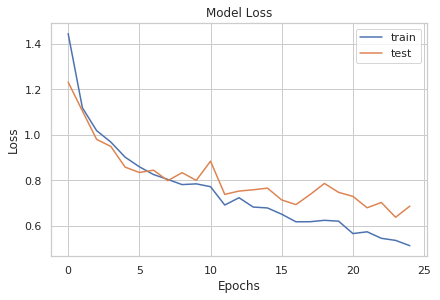

In [0]:
# построим графки зависимости потерь при обучении и тестах от эпох
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

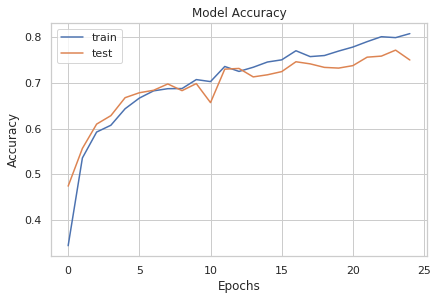

In [0]:
# построим графки зависимости точности модели при обучении и тестах от эпох
plt.plot(History.history['acc'])
plt.plot(History.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

In [0]:
loss, accuracy = model.evaluate(x_test, y_test)
print('Точность: %.2f процентов' % (accuracy*100))
print('Потери: %.2f' % (loss))

1297/1297 [==============================] - 1s 762us/step
Точность: 75.02 процентов
Потери: 0.69


In [0]:
# матрица ошибок
from sklearn.metrics import confusion_matrix
y_pred = model.predict(x_test)
# конвертируем предсказанные моделью классы в вектора 
y_pred_classes = np.argmax(y_pred,axis = 1) 
# конвертируем реальные классы в вектора 
y_true = np.argmax(y_test,axis = 1) 
# расчитываем матрицу ошибок
confusion_mtx = confusion_matrix(y_true, y_pred_classes) 

Text(0.5, 17.937499999999968, 'Реальный класс')

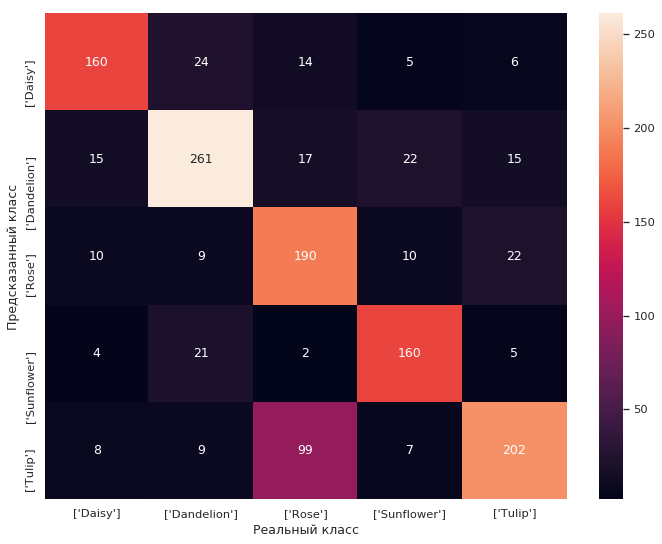

In [0]:
# строим матрицу ошибок
fig, ax = plt.subplots(1, 1, figsize = (10, 8), dpi=75)
ticks = []
for number in range(5):
    ticks.append(le.inverse_transform([number]))
sns.heatmap(confusion_mtx, xticklabels= ticks, yticklabels= ticks, 
            annot=True, fmt="d");
ax.set_ylabel('Предсказанный класс')    
ax.set_xlabel('Реальный класс')

In [0]:
# отобразим ROC-кривую
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

y_pred = model.predict(x_test)
n_classes = 5
# вычислим ROC кривую и область под этой кривой для всех классов
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

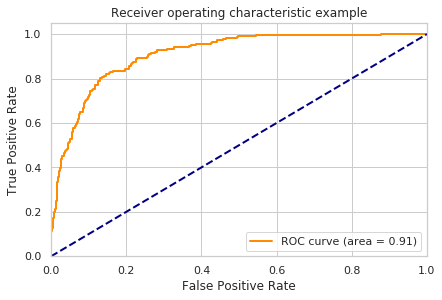

In [0]:
# отобразим кривую в виде графика
plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# Тестирование модели

In [0]:
# возьмём выходы модели на тестировочном сете
pred=model.predict(x_test)
pred_digits=np.argmax(pred,axis=1)

In [0]:
# отдельно сохраним правильные предсказания модели и неправильные
i=0
prop_class=[]
mis_class=[]

for i in range(len(y_test)):
    if(np.argmax(y_test[i])==pred_digits[i]):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(y_test)):
    if(not np.argmax(y_test[i])==pred_digits[i]):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

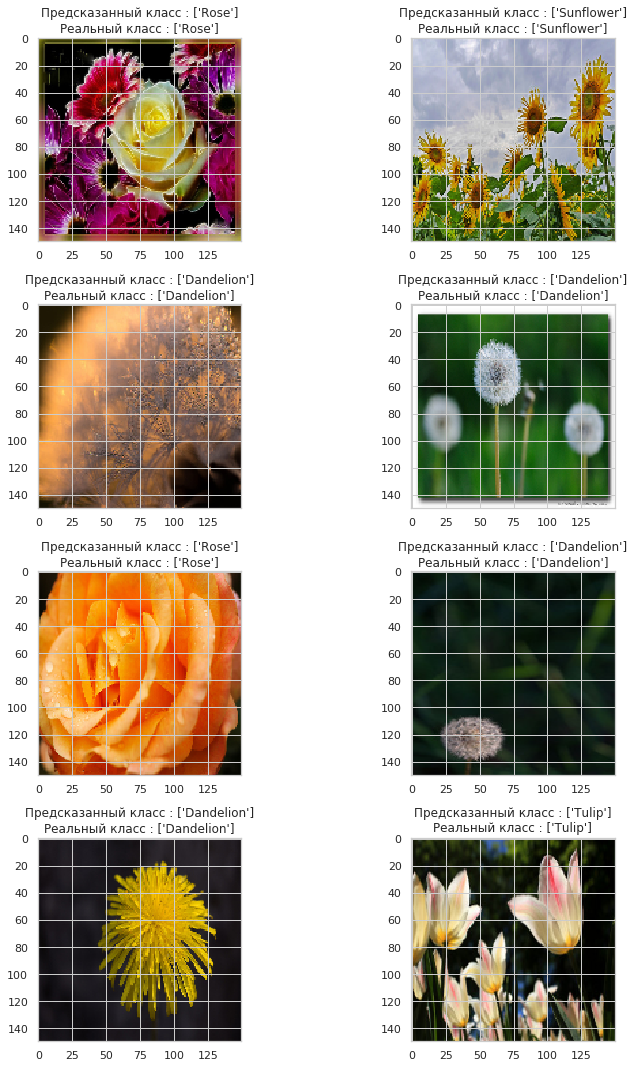

In [0]:
# игнорируем предупреждения 
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# отобразим примеры правильных предсказаний модели
count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        (B, G, R) = cv2.split(x_test[prop_class[count]])
        img = cv2.merge([R, G, B])
        ax[i,j].imshow(img)
        actual_flow=np.argmax(y_test[prop_class[count]])
        ax[i,j].set_title("Предсказанный класс : "+str(le.inverse_transform([pred_digits[prop_class[count]]]))+
                          "\n"+"Реальный класс : " +str(le.inverse_transform([actual_flow]))
                          )
        plt.tight_layout()
        count+=1

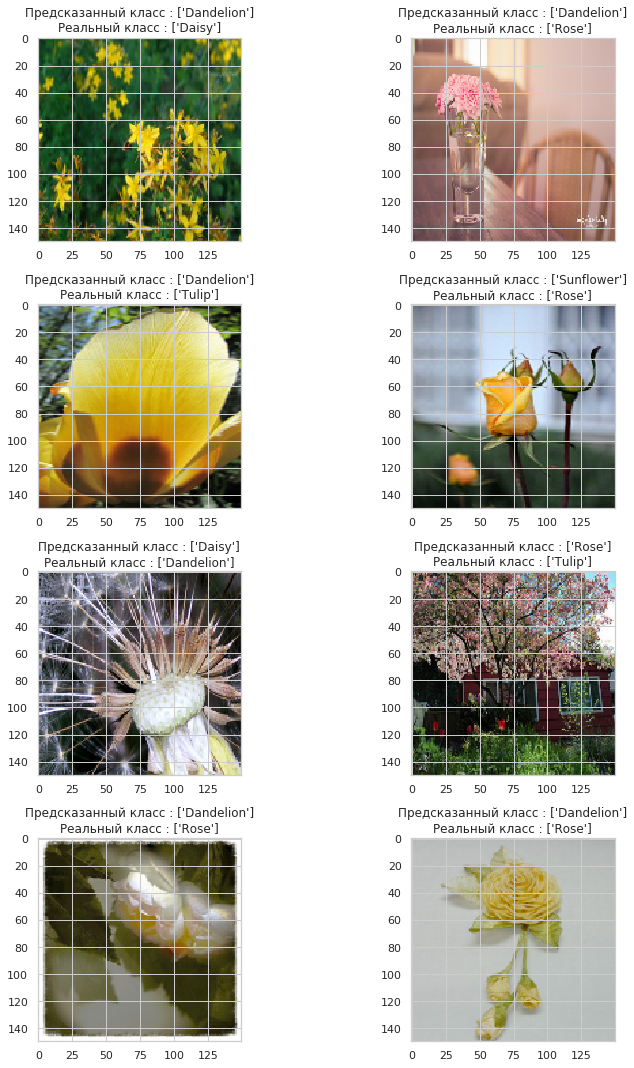

In [0]:
# отобразим примеры неправильных предсказаний модели
count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        (B, G, R) = cv2.split(x_test[mis_class[count]])
        img = cv2.merge([R, G, B])
        ax[i,j].imshow(img)
        actual_flow=np.argmax(y_test[mis_class[count]])
        ax[i,j].set_title("Предсказанный класс : "+str(le.inverse_transform([pred_digits[mis_class[count]]]))+
                          "\n"+"Реальный класс : "+str(le.inverse_transform([actual_flow]))
                         )
                         
        plt.tight_layout()
        count+=1

**Тестирование модели на единичном изображении**

In [0]:
"""
метод прогоняет изображение по модели и показывает, к какому классу изображение
относится с наибольшей вероятностью

возвращает массив вероятностей отношения изображения (по пути img_path)
к классам ('Daisy', 'Dandelion', 'Rose', 'Sunflower', 'Tulip')

"""
def predict_and_visualize(img_path, true_label):
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  img = cv2.imread(img_path,cv2.IMREAD_COLOR)
  img = cv2.resize(img, (image_size,image_size))

  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), cmap=plt.cm.binary)
  
  # конвертируем изображение в массив
  img = img_to_array(img)
  img = expand_dims(img, axis=0)
  # нормализуем изображение
  img = img / 255.0
  
  probabilities = model.predict(img)
  probabilities = probabilities[0]

  predicted_label = np.argmax(probabilities)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% (на самом деле {})"
             .format(le.inverse_transform([predicted_label]),
              100*np.max(probabilities),
              le.inverse_transform([true_label]),
              color=color))
  return probabilities

"""
Метод строит гистограмму из массива вероятностей отношения к классам
"""
def plot_probabilities_histogramm(probabilities, true_label):
  objects = ('Daisy', 'Dandelion', 'Rose', 'Sunflower', 'Tulip')
  y_pos = np.arange(len(objects))
  
  plt.grid(False)
  plt.yticks([])
  plt.xticks(y_pos,objects)
  
  thisplot = plt.bar(range(5), probabilities, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(probabilities)
  
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')


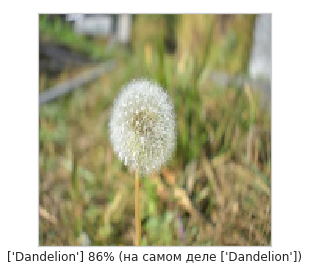

In [0]:
probs = predict_and_visualize("oduvanchik.jpg",1)

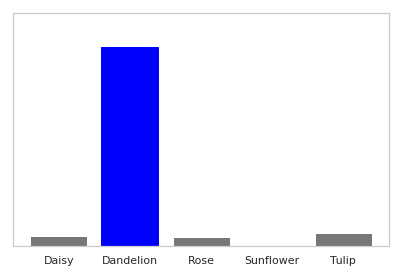

In [0]:
plot_probabilities_histogramm(probs,1)